In [1]:
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import pinocchio as pin
from pinocchio import RobotWrapper
from pinocchio.utils import zero

from momentumopt.kinoptpy.inverse_kinematics import PointContactInverseKinematics
from momentumopt.quadruped.quadruped_wrapper import Quadruped12Wrapper
from momentumopt.kinoptpy.qp import QpSolver

from momentumopt.kinoptpy.second_order_ik import SecondOrderInverseKinematics

In [2]:
def plot_com(com, com_des, lmom, lmom_des, amom, amom_des):
    plt.figure(figsize=[18,18])
    for i in range(3):
        plt.subplot(3,3,i+1)
        plt.plot(com[:,i])
        plt.plot(com_des[:,i])
        plt.subplot(3,3,i+4)
        plt.plot(lmom[:,i])
        plt.plot(lmom_des[:,i])
        plt.subplot(3,3,i+7)
        plt.plot(amom[:,i])
        plt.plot(amom_des[:,i])
        
def plot_endeff(pos, pos_ref):
    plt.figure(figsize=[18,18])
    for i in range(4):
        for j in range(3):
            plt.subplot(4,3,3*i + j + 1)
            plt.plot(pos[:,i,j])
            plt.plot(pos_ref[:,i,j])

In [13]:
data = np.load('dynamic_targets_trot.npz')
q = data['q']
dq = data['dq']
com_dyn=data['com_dyn']
lmom_dyn=data['lmom_dyn']
amom_dyn = data['amom_dyn']
endeff_pos_ref=data['endeff_pos_ref']
endeff_vel_ref=data['endeff_vel_ref']
endeff_contact=data['endeff_contact']
joint_des = data['joint_des']

In [14]:
robot = Quadruped12Wrapper()
eff_names = ['{}_{}'.format(eff, robot.joints_list[-1]) for eff in robot.effs]
inv_kin = PointContactInverseKinematics(robot.model, eff_names)
inv_kin2 = SecondOrderInverseKinematics(robot.model, eff_names)

In [15]:
q_kin, dq_kin, com_kin, lmom_kin, amom_kin, endeff_pos_kin, endeff_vel_kin = inv_kin2.solve(q, dq, com_dyn, lmom_dyn, amom_dyn,
              endeff_pos_ref, endeff_vel_ref, endeff_contact, joint_des.T)

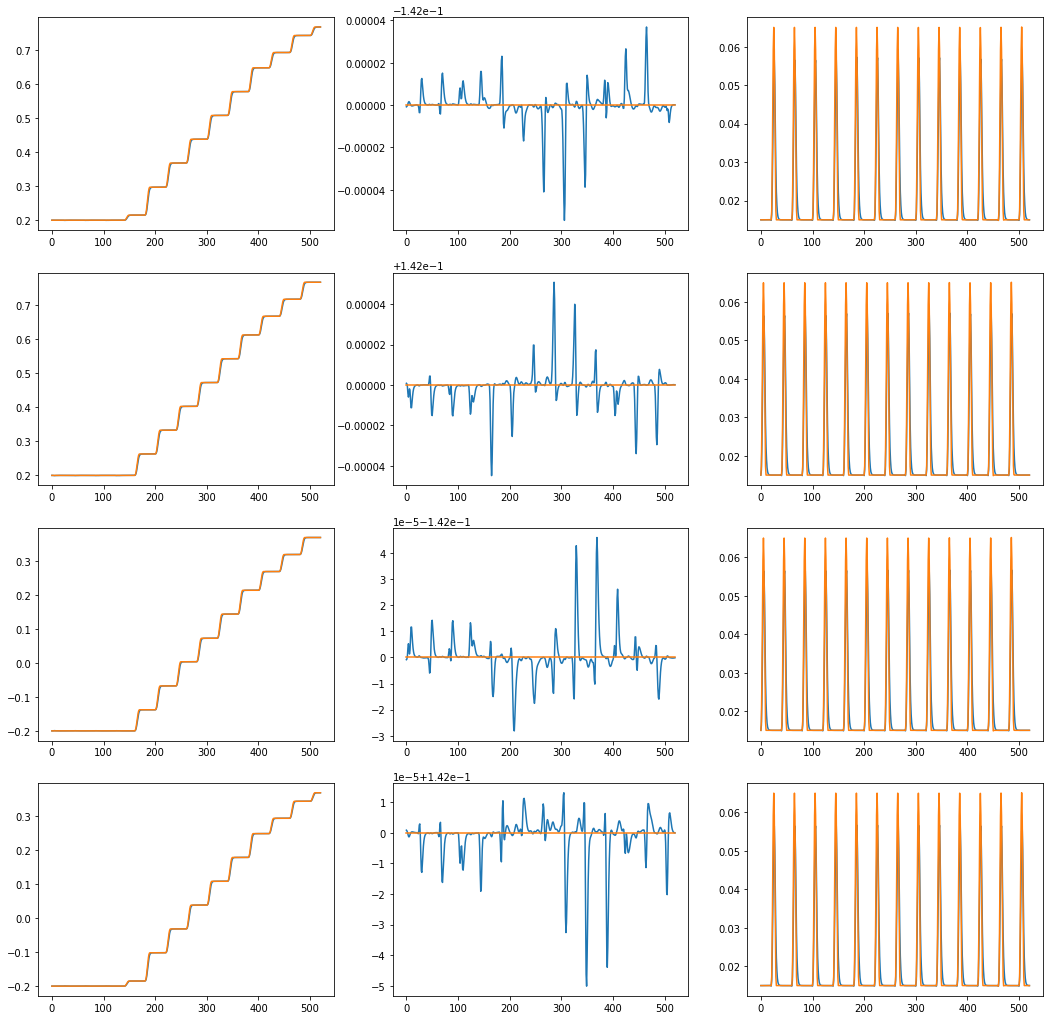

In [16]:
plot_endeff(endeff_pos_kin, endeff_pos_ref)

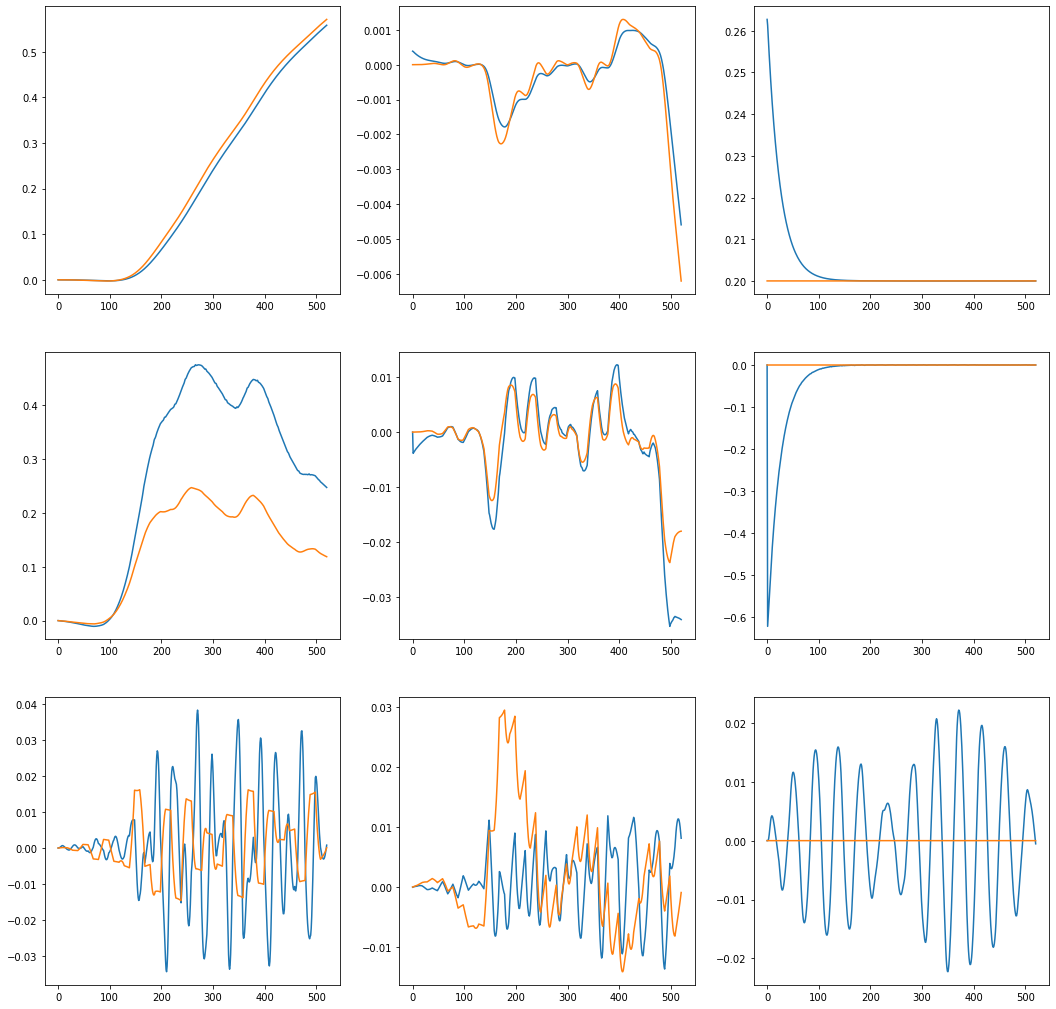

In [17]:
plot_com(com_kin, com_dyn, lmom_kin, lmom_dyn, amom_kin, amom_dyn)

In [8]:
num_time_steps = 300
reg_orientation = 1e-2
reg_joint_position = 2.

com_kin = np.zeros_like(com_dyn)
lmom_kin = np.zeros_like(lmom_dyn)
amom_kin = np.zeros_like(amom_dyn)
endeff_pos_kin = np.zeros_like(endeff_pos_ref)
endeff_vel_kin = np.zeros_like(endeff_vel_ref)
q_kin = np.zeros([num_time_steps,q.shape[0]])
dq_kin = np.zeros([num_time_steps,dq.shape[0]])

dt = 0.01

for it in range(num_time_steps):
    quad_goal = pin.Quaternion(pin.rpy.rpyToMatrix(np.zeros([3,1])))
    quad_q = pin.Quaternion(float(q[6]), float(q[3]), float(q[4]), float(q[5]))
    amom_ref = (reg_orientation * pin.log((quad_goal * quad_q.inverse()).matrix()).T + amom_dyn[it]).reshape(-1)

    joint_regularization_ref = reg_joint_position * ((joint_des[:,it]).T - q[7 : ])
    # joint_regularization_ref = self.reg_joint_position * (self.q_init[7 : ] - q[7 : ])

    # Fill the kinematics results for it.
    inv_kin.forward_robot(q, dq)

    def framesPos(frames):
        return np.vstack([inv_kin.robot.data.oMf[idx].translation for idx in frames]).reshape([4,3])

    data = inv_kin.robot.data
    hg = inv_kin.robot.centroidalMomentum(q, dq)

    # Storing on the internal array.
    com_kin[it] = inv_kin.robot.com(q).T
    lmom_kin[it] = hg.linear.T
    amom_kin[it] = hg.angular.T
    q_kin[it] = q.T
    dq_kin[it] = dq.T

    # The endeffector informations as well.
    endeff_pos_kin[it] = framesPos(inv_kin.endeff_ids)
    endeff_vel_kin[it] = (inv_kin.J[6:(inv_kin.ne + 2) * 3].dot(dq).T).reshape([4,3])

    dq = inv_kin.compute(
            q, dq, com_dyn[it], lmom_dyn[it], amom_ref,
            endeff_pos_ref[it], endeff_vel_ref[it],
            endeff_contact[it], joint_regularization_ref)

    # Integrate to the next state.
    q = pin.integrate(robot.model, q, dq * dt)

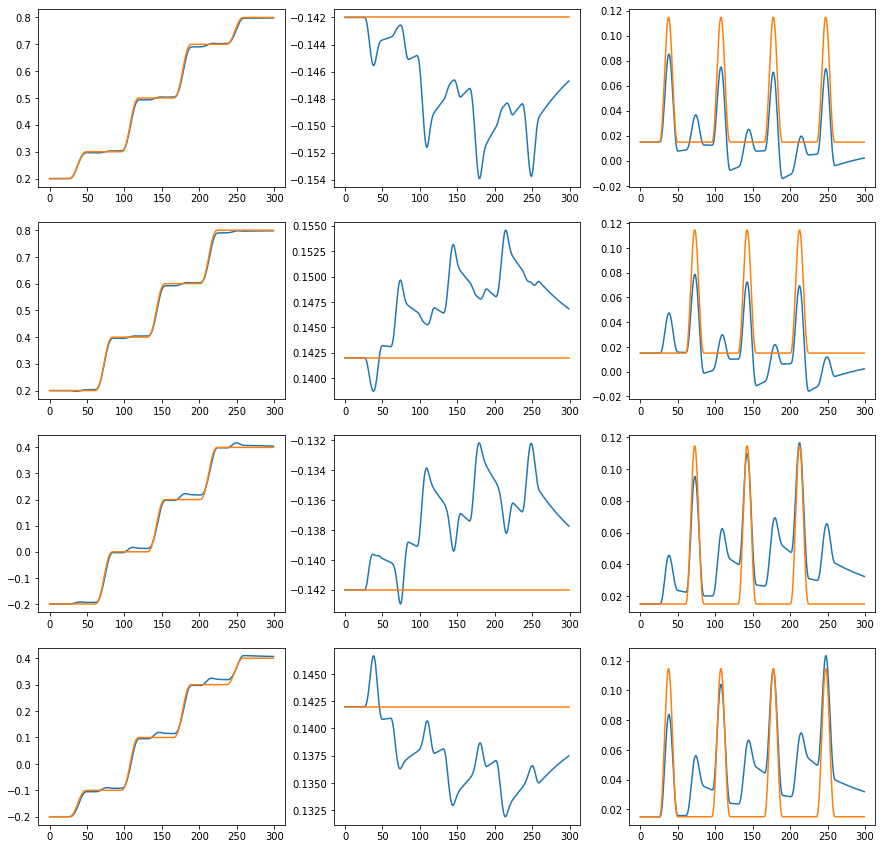

In [9]:
plot_endeff(endeff_pos_kin, endeff_pos_ref)

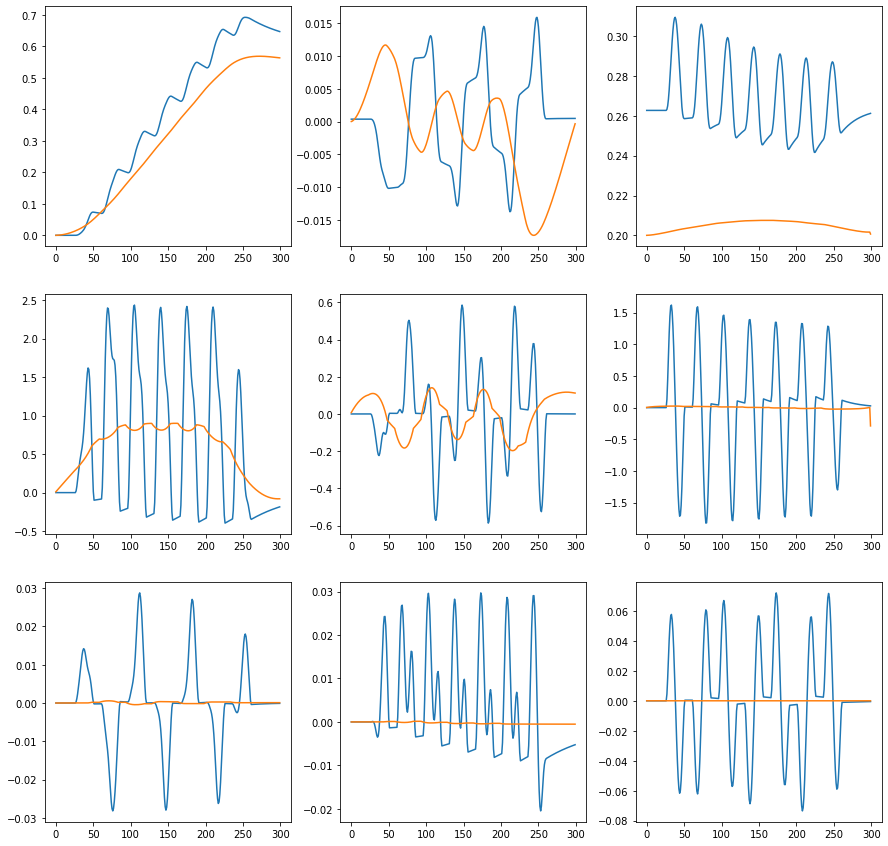

In [10]:
plot_com(com_kin, com_dyn, lmom_kin, lmom_dyn, amom_kin, amom_dyn)

In [11]:
joint_des.shape

(12, 300)

In [114]:
from scipy.interpolate import CubicHermiteSpline, CubicSpline, UnivariateSpline, interp1d

TypeError: __call__() got an unexpected keyword argument 'nu'

<Figure size 432x288 with 0 Axes>

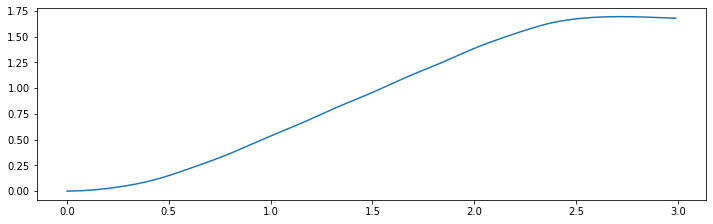

In [115]:
num_time_steps = com_dyn.shape[0]
dt = 0.01
mass = 2.978
index = 0
time = np.linspace(0., (num_time_steps-1)*dt, num_time_steps)
time_small = np.linspace(0., (num_time_steps-1)*dt, num_time_steps*10)
splined_com_dyn = interp1d(time, mass*com_dyn[:,index])
plt.figure()
# for i in range(3):
#     plt.subplot(3,1,i+1)
#     plt.plot(time, mass*com_dyn[:,i])
#     plt.plot(time_small, splined_com_dyn(time_small)[:,i])

plt.figure(figsize=[12,12])
# splined_com_dyn.set_smoothing_factor(0.00000)
plt.subplot(3,1,1)
plt.plot(time, mass*com_dyn[:,index])
plt.plot(time_small, splined_com_dyn(time_small, nu=0))
plt.subplot(3,1,2)
plt.plot(time, lmom_dyn[:,index])
plt.plot(time_small, splined_com_dyn(time_small, nu=1))
plt.subplot(3,1,3)
plt.plot(time[:-1], np.diff(lmom_dyn[:,index])/dt)
plt.plot(time_small, splined_com_dyn(time_small, nu=2))

In [53]:
inv_kin2.robot_mass

2.5000027900000004

In [36]:
joint_des = np.loadtxt('quad_trot/quadruped_generalized_positions.dat')
joint_des.shape

(10420, 20)

In [67]:
lmom_dyn = np.loadtxt('quad_trot/quadruped_centroidal_forces.dat')[:,1:]
amom_dyn = np.loadtxt('quad_trot/quadruped_lmom_old.dat')[:,1:]
com_dyn = np.loadtxt('quad_trot/quadruped_com.dat')[:,1:]
endeff_pos_ref = np.loadtxt('quad_trot/quadruped_positions_abs.dat')[:,1:].reshape((-1,4,3))
endeff_vel_ref = np.loadtxt('quad_trot/quadruped_velocities_abs.dat')[:,1:].reshape((-1,4,3))
endeff_contact = np.loadtxt('quad_trot/quadruped_contact_activation.dat')[:,1:]


In [52]:
lmom_dyn.shape

(11000, 3)

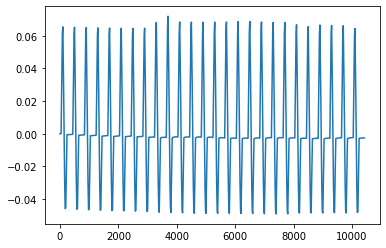

In [69]:
plt.plot(amom_dyn[:,2])